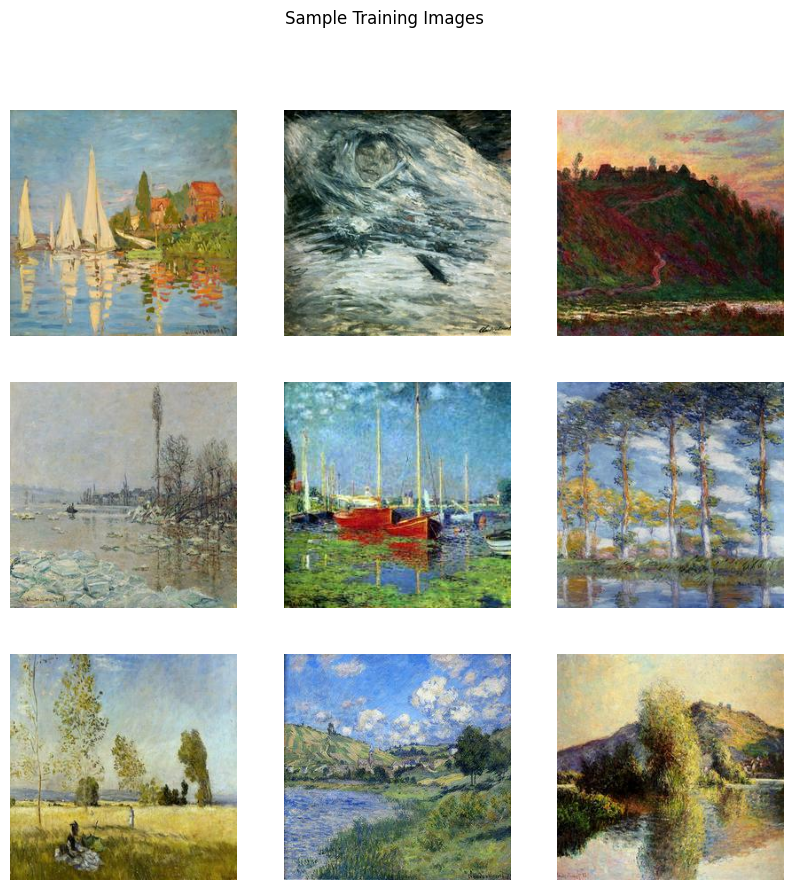

In [3]:
# Assignment 5
# Kaggle GAN
# url:  https://www.kaggle.com/competitions/gan-getting-started

# Rahf Noor
# github repo: https://github.com/Rahf/csca5642-assignment-5


# Monet/Dog Image Generation with GANs
# This notebook tackles the "GANs Getting Started" competition on Kaggle. The goal is to train a Generative 
# Adversarial Network (GAN) to generate images similar to a given dataset—either Monet paintings or dog 
# images—and evaluate them using the MiFID metric.

# Step 1: Setup + Data Loading

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

# Unzipping and loading dataset
data_path = "data/"
train_dir = os.path.join(data_path, "monet_jpg")
sample_image_paths = glob(train_dir + "/*.jpg")

# print("sample image paths", sample_image_paths)

# Display sample images
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_image_paths[:9]):
    img = Image.open(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

In [4]:
# EDA step
# process images

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = glob(os.path.join(folder_path, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

dataset = ImageDataset(train_dir, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [5]:
# build the GAN model

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [14]:
# train the GAN model
# going with 10 Epochs just to speed up processing

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

MAX_EPOCHS = 10

fixed_noise = torch.randn(16, 100, 1, 1).to(device)

for epoch in range(MAX_EPOCHS):
    for real_imgs in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
    
        # Discriminator step
        real_output = discriminator(real_imgs)
        real_labels = torch.ones_like(real_output).to(device)
        d_loss_real = criterion(real_output, real_labels)

        # Generate `fake` images for loss computation
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        fake_labels = torch.zeros_like(fake_output).to(device)  # <- CORRECTED HERE
        d_loss_fake = criterion(fake_output, fake_labels)
    
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()
    
        # Generator step
        gen_output = discriminator(fake_imgs)
        gen_labels = torch.ones_like(gen_output).to(device)  # <- CORRECTED HERE
        g_loss = criterion(gen_output, gen_labels)
    
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


    print(f"Epoch [{epoch+1}/10] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [1/10] D Loss: 1.7878, G Loss: 0.6105
Epoch [2/10] D Loss: 1.5620, G Loss: 0.8695
Epoch [3/10] D Loss: 1.6388, G Loss: 0.8430
Epoch [4/10] D Loss: 1.5538, G Loss: 0.9659
Epoch [5/10] D Loss: 1.5542, G Loss: 0.9811
Epoch [6/10] D Loss: 1.3946, G Loss: 1.1081
Epoch [7/10] D Loss: 1.1911, G Loss: 1.3681
Epoch [8/10] D Loss: 1.3768, G Loss: 1.1793
Epoch [9/10] D Loss: 1.1872, G Loss: 1.3180
Epoch [10/10] D Loss: 0.9889, G Loss: 1.7173


In [15]:
# Create submission files

output_dir = "./images"
os.makedirs(output_dir, exist_ok=True)

generator.eval()
for i in range(10000):  # Number of images required
    z = torch.randn(1, 100, 1, 1).to(device)
    with torch.no_grad():
        fake_img = generator(z).detach().cpu()
    img = transforms.ToPILImage()(fake_img.squeeze(0).clamp(-1, 1) * 0.5 + 0.5)
    img.save(f"{output_dir}/{i:05}.png")

In [16]:
# Conclusion

print(f"""
The goal was to successfully built a DCGAN model to generate synthetic images mimicking the dataset. 
The GAN was trained for a few epochs and began generating plausible outputs. Final images were saved 
in the required format for submission to Kaggle, and the MiFID metric will evaluate how well the GAN 
learned the data distribution.

Further improvements could involve longer training, improved architectures (e.g., StyleGAN), and data augmentation.
""")



The goal was to successfully built a DCGAN model to generate synthetic images mimicking the dataset. 
The GAN was trained for a few epochs and began generating plausible outputs. Final images were saved 
in the required format for submission to Kaggle, and the MiFID metric will evaluate how well the GAN 
learned the data distribution.

Further improvements could involve longer training, improved architectures (e.g., StyleGAN), and data augmentation.

